In [2]:
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import math
import time
from keras.datasets import mnist
from keras.datasets import cifar10

Using TensorFlow backend.


In [3]:
def getEuclideanDistance(single_point,array):
    nrows, ncols, nfeatures=array.shape[0],array.shape[1], array.shape[2]
    points=array.reshape((nrows*ncols,nfeatures))
                         
    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    dist=dist.reshape((nrows,ncols))
    return dist

In [4]:

mu, sigma = 0, 0.1
A = np.random.normal(mu, sigma, 10)
#A.shape, A

In [5]:
nrows,ncols,nfeatures=3,3,3

#Generate coordinate system
x,y=np.meshgrid(range(ncols),range(nrows))

In [6]:

sgm0=2
sgmdecay=0.05
t=1
sgm = sgm0 * math.exp(-t*sgmdecay);

width = math.ceil(sgm*3)

dist=np.array([[2,1,3],[3,2,3],[4,4,4]])
bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) 

g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));


fromrow = max(0,bmurow - width);
torow   = min(bmurow + width,nrows);
fromcol = max(0,bmucol - width);
tocol   = min(bmucol + width,ncols);



In [7]:
G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);



In [8]:
def SOM (dispRes, trainingData, ndim=10, nepochs=10, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    mu, sigma = 0, 0.1
    numpy.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows,ncols,nfeatures))

    if showMode >= 1:
        print("\nSOM features before training: \n")
        
        fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        for k in range(nrows):
            for l in range (ncols):
                A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
                ax[k,l].imshow(A,cmap="plasma")
                ax[k,l].set_yticks([])
                ax[k,l].set_xticks([])   
    
    #Generate coordinate system
    x,y=np.meshgrid(range(ncols),range(nrows))
    
    
    for t in range (1,nepochs+1):
        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t*etadecay);
        
        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t*sgmdecay);
        
        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3);
        
        for ntraining in range(ntrainingvectors):
            trainingVector = trainingData[ntraining,:];
            
            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = getEuclideanDistance(trainingVector, som);
       
            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
            
            
            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));

            #Determine the boundary of the local neighbourhood
            fromrow = max(0,bmurow - width);
            torow   = min(bmurow + width,nrows);
            fromcol = max(0,bmucol - width);
            tocol   = min(bmucol + width,ncols);

            
            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbourNeurons = som[fromrow:torow,fromcol:tocol,:];
            sz = neighbourNeurons.shape;
            
            #Transform the training vector and the Gaussian function into 
            # multi-dimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(trainingVector,sz[0]*sz[1],1).reshape((sz[0],sz[1],nfeatures));                   
            G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons);

            
            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow,fromcol:tocol,:] = neighbourNeurons;
            
        if ((t == nepochs//2) & (showMode >= 1)):
            print("\nSOM features AFTER 50%: \n")
        
            fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

            for k in range(nrows):
                for l in range (ncols):
                    A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
                    ax[k,l].imshow(A,cmap="plasma")
                    ax[k,l].set_yticks([])
                ax[k,l].set_xticks([])

    if showMode >= 1:
        print("\nSOM features AFTER training: \n")
        
        fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        for k in range(nrows):
            for l in range (ncols):
                A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
                ax[k,l].imshow(A,cmap="plasma")
                ax[k,l].set_yticks([])
            ax[k,l].set_xticks([])   
    return som
    

In [9]:
plt.show()

In [10]:
#verification of correctness on the training set:
def SOM_Test (trainingData, som_, classes, grid_, ConfusionMatrix, ndim=60):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    nclasses=len(classes)

    som_cl=np.zeros((ndim,ndim,nclasses+1))
    
    
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        
        som_cl[bmurow, bmucol,class_of_sample]=som_cl[bmurow, bmucol,class_of_sample]+1
    
    
    
    for i in range (nrows):
        for j in range (ncols):
            grid_[i,j]=np.argmax(som_cl[i,j,:])

 
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        predicted=np.argmax(som_cl[bmurow, bmucol,:])
        ConfusionMatrix[class_of_sample-1, predicted-1]=ConfusionMatrix[class_of_sample-1, predicted-1]+1
        
    return grid_, ConfusionMatrix
    



In [11]:
def classification(dataSet, labelSet, somTrained, ndim, imshow=0):
    nrows=ndim
    ncols=ndim
    grid_color=np.zeros((nrows,ncols))
    nclasses=len(labelSet)
    Confusion_Matrix=np.zeros((10, 10))

    grid_color,Confusion_Matrix=SOM_Test (dataSet, somTrained, labelSet, grid_color, Confusion_Matrix, ndim)
    
    if imshow >= 1:
        plt.close()
        plt.imshow(grid_color)
        plt.show()
        plt.close()

        plt.imshow(Confusion_Matrix)
        plt.show()
        plt.close()
    return grid_color, Confusion_Matrix

In [12]:
#Load the MNIST data
(Xtr, Ltr), (X_test, L_test)=mnist.load_data()
num_sample = 100
num_test = 100
Tr_set = Xtr[:num_sample,:,:]
Ltr_set = Ltr[:num_sample]
test_set = X_test[:num_test,:,:]
Ltest_set = L_test[:num_test]

#Flatten
Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2]).astype(int)
Test_images = test_set.reshape(test_set.shape[0],test_set.shape[1]*test_set.shape[2])

#Define classes
#Tclasses = Ltr_set #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
print("20x20 grid:")
somTrained_20 = SOM([28, 28], Tr_set, ndim=20, nepochs=30, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)

20x20 grid:

SOM features before training: 



KeyboardInterrupt: 

In [ ]:
print("40x40 grid:")
somTrained_20 = SOM([28, 28], Tr_set, ndim=40, nepochs=30, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)

In [ ]:
print("80x80 grid:")
somTrained_20 = SOM([28, 28], Tr_set, ndim=80, nepochs=30, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)

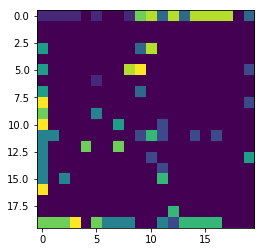

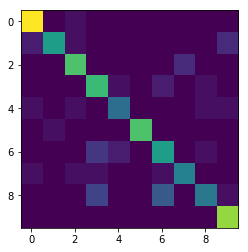

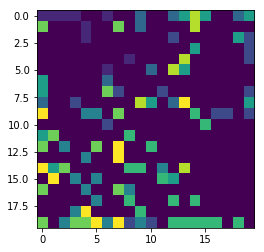

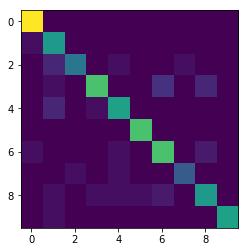

In [48]:
classification(Tr_set, Ltr_set, somTrained_20, 20, imshow=1)
classification(Test_images, Ltest_set, somTrained_20, 20, imshow=1)

In [19]:
maxEta = 0
maxAccE = 0
for eta in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]:
    etaTest = SOM([28, 28], Tr_set, ndim=20, nepochs=30, eta0=eta, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0)
    grid_color, Confusion_Matrix = classification(Test_images, Ltest_set, etaTest, 20, imshow=0)
    dSum = np.sum(np.diagonal(Confusion_Matrix))
    if dSum > maxAccE:
        maxEta = eta
        maxAccE = dSum
    print("eta =", eta, ":", dSum)
print("Max accuracy was: " + str(maxAccE) + " at eta = " + str(maxEta))

eta = 0.1 : 89.0
eta = 0.3 : 92.0
eta = 0.5 : 79.0
Max accuracy was: 92.0 at eta = 0.3


In [22]:
maxSgm = 0
maxAccS = 0
for sgm in [2, 5, 8, 11, 14, 17, 20, 23]:
    etaTest = SOM([28, 28], Tr_set, ndim=20, nepochs=30, eta0=0.3, etadecay=0.05, sgm0=sgm, sgmdecay=0.05, showMode=0)
    grid_color, Confusion_Matrix = classification(Test_images, Ltest_set, etaTest, 20, imshow=0)
    dSum = np.sum(np.diagonal(Confusion_Matrix))
    if dSum > maxAccS:
        maxSgm = sgm
        maxAccS = dSum
    print("Sigma =", sgm, ":", dSum)
print("Max accuracy was: " + str(maxAccS) + " at Sigma = " + str(maxEta))

Sigma = 2 : 93.0
Sigma = 5 : 89.0
Sigma = 8 : 96.0
Sigma = 11 : 90.0
Sigma = 14 : 91.0
Sigma = 17 : 95.0
Sigma = 20 : 93.0
Sigma = 23 : 92.0
Max accuracy was: 96.0 at Sigma = 0.3
